_Neural Data Science_

Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Ziwei Huang, Rita González Márquez

Summer term 2022

Student names: *Marina Dittschar & Clarissa Auckenthaler*

# Coding Lab 2

If needed, download the data files ```nda_ex_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```. Use a subset of the data for testing and debugging. But be careful not to make it too small, since the algorithm may fail to detect small clusters in this case. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import signal, special
from scipy.special import logsumexp
from sklearn.cluster import KMeans
import scipy as sp
from scipy.io import loadmat
import copy
import math
from scipy import linalg, stats
from sklearn.mixture import GaussianMixture
import sys
import scipy
from scipy import signal 


sns.set_style('whitegrid')
%matplotlib inline

## Load data

In [2]:
# replace by path to your solutions
b = np.load(r'data\nda_ex_1_featuresnpy.sec')
s = np.load(r'data\nda_ex_1_spiketimes_snpy.sec')
w = np.load(r'data\nda_ex_1_waveformsnpy.sec')
np.random.seed(0)

## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 1 pts*


In [3]:
def sample_data(N, m, S, p):
    
    '''Generate N samples from a Mixture of Gaussian distribution with 
    means m, covariances S and priors p.
    
    Parameters
    ----------
    
    N: int
        Number of samples
    
    m: list or np.array, (n_clusters, n_dims)
        Means
    
    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances
    
    p: list or np.array, (n_clusters, )
        Cluster weights / probablities
    
    Returns
    -------
    
    x: np.array, (n_samples, n_dims)
        Data points
    
    ind: np.array, (n_samples,)
        Labels.
    '''
    # insert your code here

    # ------------------------------------------------------
    # draw labeled points from mixture of Gaussians (0.5 pt)
    # ------------------------------------------------------
    # set random seed
    np.random.seed(0)
    # get N random samples
    random_samples = np.random.rand(N)
    pi_low = 0
    labels = []
    x_samples = []
    y_samples = []
    for d in range(p.shape[0]):
        # get the means and covs corresponding to the cluster
        mean = m[d] 
        cov = S[d] 
        # set the new random upper limit
        pi_high = p[d] + pi_low
        # get the number of samples that fall in the allowed range for the iteration
        n_samples = sum(np.logical_and(random_samples < pi_high, random_samples>pi_low))
        # get the samples
        x, y = np.random.multivariate_normal(mean, cov, n_samples).T
        x_samples = np.append(x_samples, x)
        y_samples = np.append(y_samples, y)
        labels = np.append(labels, np.repeat(d, n_samples))
        # update new "lowest" probability
        pi_low = pi_high

    
    samples = np.vstack((x_samples, y_samples))
    print(samples.shape)
    
    return (labels, samples)    


In [4]:
# N = 1000 # total number of samples

means = np.asarray([[5,1], [0,4], [0,0]])
covs = np.asarray([[[2,1], [1,2]], [[1,-0.5], [-0.5, 1]], [[1,0], [0,1]]])
ps = np.asarray([0.3, 0.5, 0.2])
labels, x = sample_data(N=1000, m = means, S = covs, p = ps)

(2, 1000)


In [5]:

def labels_to_str(labels):
    """
    Convert probability labels to string color labels
    
    Parameters
    ----------
    labels: array
    Assigned probabilities
    
    Returns 
    -------
    string_labels: 1-D array
    labels converted to colors
    
    """
    labels = np.argmax(labels, axis=0)
    string_labels = labels.astype("str")
    string_labels[labels==0] = "k"
    string_labels[labels==1] = "r"
    string_labels[labels==2] = "b"
    string_labels[labels==3] = "g"
    string_labels[labels==4] = "purple"
    string_labels[labels==5] = "lightgreen"
    string_labels[labels==6] = "lightblue"
    string_labels[labels==7] = "yellow"
    string_labels[labels==8] = "orange"
    string_labels[labels==9] = "cyan"
    string_labels[labels==10] = "gray"
    string_labels[labels==11] = "brown"
    
    return string_labels

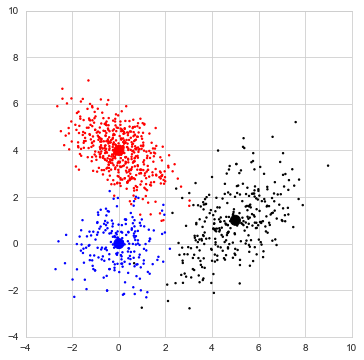

In [6]:
plt.figure(figsize=(6, 6))

string_labels1 = labels.astype("str")
string_labels1[labels==0] = "k"
string_labels1[labels==1] = "r"
string_labels1[labels==2] = "b"
ax = plt.subplot(1,1,1, aspect='equal')
plt.scatter(x[0], x[1], color=string_labels1, s=2)
plt.scatter(means[:,0], means[:,1], s=100,  c=np.asarray(["k", "r", "b"]))

plt.xlim(-4,10)
plt.ylim(-4, 10)

plt.show()

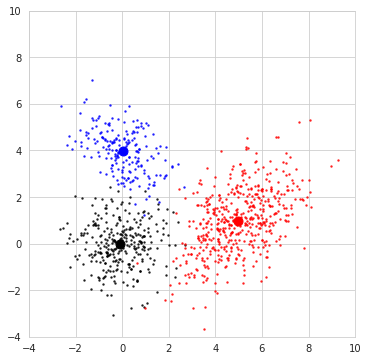

## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `fit_mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.  

*Grading: 4 pts*


In [7]:
def random_centroids(x, k):
    """
    Get random centroids for K-Means
    
    Parameters
    ----------
    x: array (n_samples, n_dim)
    data to adapt centroids to
    
    k: int
    number of clusters
    
    Returns
    -------
    centroids: array (n_clusters, n_dims)
    Array with centroids 

    """
    centroids = np.empty((0,x.shape[1]))
    for c in np.arange(k):
        centroid = np.random.rand(1,x.shape[1])
        centroids = np.append(centroids, centroid, axis=0)
    return centroids

In [8]:
def sample_dist(x, k, centroids):
    """ 
    Get the distance from each sample to each centroid
    
    Parameters
    ----------
    x: array (n_samples, n_dim)
    data to measure distance to
    
    k: int
    number of clusters
    
    centroids: array (n_clusters, n_dims)
    Array with centroids
    
    Returns
    -------
    
    dist_all: array (n_clusters, n_samples)
    Distance from every sample to every cluster
    
    
    """
    dist_all = np.empty((0, x.shape[0]))
    for c in np.arange(k):
        dist_x = x - centroids[c, 0]
        dist_xx = dist_x**2
        dist = np.empty((x.shape[0]))
        for i in np.arange(x.shape[1]):
            dist = dist + dist_xx[:,i]
        dist_all = np.append(dist_all, np.expand_dims(np.sqrt(dist), axis=0), axis=0)
    return dist_all

In [9]:
def cluster_dist(x, c,  hard_labels):
    """ 
    compute a new centroid according to hard label assignments
    
    Parameters
    ----------
    x: array (n_samples, n_dim)
    data 
    
    c: int
    nth cluster
    
    hard_labels: array (n_samples, )
    Array with int label assignments
    
    Returns
    -------
    
    avg_dist: 
    Distance from each cluster sample to the cluster  
    
    centroid: array (n_samples,)
    new centroids derived from hard labels
    """
    avg_dists = []
    centroid = np.empty((x.shape[1]))
    x_hard = x[hard_labels==c]
    centroid = x_hard.mean(axis=0)
    dist_c_x = x[hard_labels==c] - centroid
    dist_c = np.empty((x_hard.shape[0]))

    for i in np.arange(x.shape[1]):
        dist_c = dist_c + dist_c_x[:,i]**2
    avg_dist = np.sqrt(dist_c)
        

    return avg_dist, centroid

In [10]:
def init_params(x, k, random_seed):
    """
    Get robust distribution parameters using K-means
    
    Parameters
    ----------
    
    x: array (n_samples, n_dims)
    data
    
    k: int
    number of clusters
    
    random_seed: int
    random seed
    
    Returns
    -------
    
    weights: array (n_clusters,)
    distribution weights
    
    centroids: array (n_clusters, n_dims)
    distribution means
    
    covs: array (n_clusters, n_dims, n_dims)
    distribution variances
    
    """
    np.random.seed(random_seed)
    covs = np.empty((0, x.shape[1], x.shape[1]))
    for c in np.arange(k):
        # create random variance matrix and scale it using max datapoint of x
        matrix = np.random.rand(x.shape[1], x.shape[1])*(np.max(x)/10)
        matrix = np.dot(matrix, matrix.T)
        covs = np.append(covs, np.expand_dims(matrix, axis=0), axis=0)

    # w1-d array of all pi-factors
    weights = np.random.random_sample(size=(k, ))
    weights = weights/np.sum(weights)

    
    mean_avg_dist = []
    centroids = random_centroids(x, k)

        
    print()
    while True:
        flag = False
        if len(mean_avg_dist) > 2 and 0 <= abs(mean_avg_dist[-1] - mean_avg_dist[-2]) < .4:
            weights = []
            for c in np.arange(k):
                weights = np.append(weights, sum(hard_labels == c)/len(hard_labels))
            break

        else:
            # get the distance from every sample to every cluster
            dist_all = sample_dist(x,k, centroids)
            # assign hard labels
            hard_labels = np.argmin(dist_all, axis=0)
            # reset centroids
            centroids = np.empty((0, x.shape[1]))
            avg_dists = []
            
            for c in np.arange(k):
                # start the process anew if any clusters have zero samples in them
                if np.sum(hard_labels==c) == 0:
                    centroids = random_centroids(x, k)
                    flag= True
                    break
#                     
#                     avg_dists = cluster_dist(x, k, centroids, hard_labels)
#                     mean_avg_dist = np.append(mean_avg_dist, avg_dists.mean())
                else:
                    # compute new centroids from the data and hard labels
                    avg_dist, centroid = cluster_dist(x, c, hard_labels)
                    avg_dists = np.append(avg_dists, avg_dist)
                    centroids = np.append(centroids, np.expand_dims(centroid, axis=0), axis=0)
            if flag:
                    break
            mean_avg_dist = np.append(mean_avg_dist, avg_dists.mean())
            
    # if there are any nans in the parameters, start the process again
    if True in np.isnan(covs) or True in np.isnan(centroids) or True in np.isnan(weights):
        init_params(x, k, random_seed)
            

    return weights, centroids, covs

In [11]:
def fit_mog(x,k, niters=10, random_seed=0):
    
    '''Fit Mixture of Gaussian model using EM algo.
    
    Parameters
    ----------
    
    x: np.array, (n_samples, n_dims)
        Input data
        
    k: int
        Number of clusters
        
    random_seed: int or None
        Random Seed
    
    
    Returnsmog_vectorized = mog
    -------
    
    mlls: np.array(n_iterations,)
    Array of Log-Likelihoods determined during computation
        
    pis: list or np.array, (n_clusters, )
        Cluster weights / probablities
        
    mus: list or np.array, (n_clusters, n_dims)
        Means
    
    sigmas: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances
    
    labels: np.array, (n_samples)
        Cluster labels
    
    '''
    np.random.seed(random_seed)
    # fill in your code here
    pis, mus, sigmas = init_params(x, k, random_seed)

    print()
    
    D = x.shape[1]
    N = x.shape[0]

    # -----------
    # init (1 pt)
    # -----------
 
    mlls = []
    iter = 0
    
    while True:
        if len(mlls) > 2 and (mlls[-1] - mlls[-2]) < 0.0001:
            break
        
        iter = iter + 1
        
        log_labels = np.empty((0, x.shape[0]))

    # -------------------------
    # EM maximisation (2.5 pts)
    # -------------------------
        # e-step
        for cluster in np.arange(k):
            pis_c = pis[cluster]
            mus_c = mus[cluster,:]
            sigma_c = sigmas[cluster,:]
            normal_c = stats.multivariate_normal(mus_c, sigma_c).pdf(x)
            log_cluster_labels = np.log(pis_c)+np.log(np.clip(normal_c, a_min = -10000, a_max=None))
            log_labels = np.append(log_labels, np.expand_dims(log_cluster_labels, axis=0), axis=0)
            
        # divide by sum
        log_labels_sum = logsumexp(log_labels, axis=0)        
        labels = np.exp(log_labels - np.expand_dims(log_labels_sum, axis=0))    
        mll = np.mean(log_labels_sum)        
        mlls = np.append(mlls,mll)
        
        
        # m-step
        pis = np.empty((k))
        n_k = np.sum(labels, axis=1)
        pis = n_k/labels.shape[1]
        mus = np.empty((0,x.shape[1]))
        sigmas = np.empty((0,x.shape[1], x.shape[1]))
        
        for cluster in np.arange(k):
            # not hard assign, but sum of all probabilities
            mus_k = np.dot(labels[cluster, :].T,x)/n_k[cluster]
            mus_tile = np.tile(mus_k, reps =(x.shape[0], 1))
            mus = np.append(mus, np.expand_dims(mus_k, axis=0), axis = 0)
            x_centered = x - mus_tile
            weighted = x_centered.T*labels[cluster,:]
            sigma = np.dot(weighted, x_centered)/n_k[cluster]
            sigmas = np.append(sigmas, np.expand_dims(sigma, axis=0), axis=0)
        if True in np.isnan(sigmas) or True in np.isnan(mus) or True in np.isnan(pis):
            pis, mus, sigmas = init_params(x, k, random_seed)
        
        
    print(f"Iterations: {iter}\nMean Log-Likelihood: {mll}")
    
    return mlls, pis, mus, sigmas, labels



Run Mixture of Gaussian on toy data

In [12]:
mll2, pis2, mus2, sigmas2, labels2= fit_mog(x.T,2, random_seed=2)
mll3, pis3, mus3, sigmas3, labels3= fit_mog(x.T,3, random_seed=10)
mll4, pis4, mus4, sigmas4, labels4= fit_mog(x.T,4, random_seed=42)
mll5, pis5, mus5, sigmas5, labels5= fit_mog(x.T,5, random_seed=20)
mll6, pis6, mus6, sigmas6, labels6= fit_mog(x.T,6, random_seed=6)
mll7, pis7, mus7, sigmas7, labels7= fit_mog(x.T,7, random_seed=0)



Iterations: 12
Mean Log-Likelihood: -3.961727851599234


Iterations: 30
Mean Log-Likelihood: -3.8476959554748187




C:\Users\marid\AppData\Local\Temp/ipykernel_7120/378093962.py:31: RuntimeWarning: invalid value encountered in sqrt
  dist_all = np.append(dist_all, np.expand_dims(np.sqrt(dist), axis=0), axis=0)
C:\Users\marid\AppData\Local\Temp/ipykernel_7120/28236725.py:34: RuntimeWarning: invalid value encountered in sqrt
  avg_dist = np.sqrt(dist_c)
C:\Users\marid\AppData\Local\Temp/ipykernel_7120/3297716506.py:70: RuntimeWarning: divide by zero encountered in log
  log_cluster_labels = np.log(pis_c)+np.log(np.clip(normal_c, a_min = -10000, a_max=None))


Iterations: 28
Mean Log-Likelihood: -3.846237462524644


Iterations: 20
Mean Log-Likelihood: -3.8398362415004534


Iterations: 43
Mean Log-Likelihood: -3.8381436129291733


Iterations: 41
Mean Log-Likelihood: -3.823494929790918


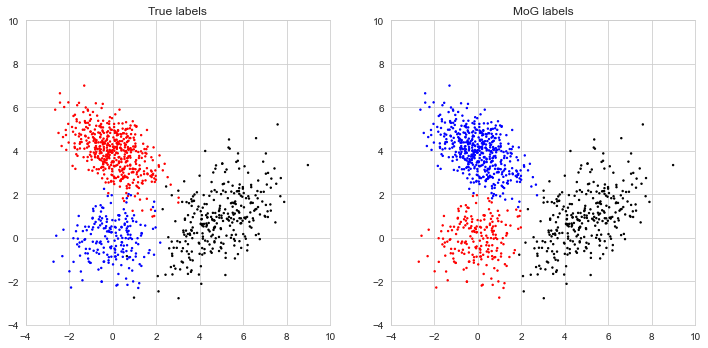

In [13]:
plt.figure(figsize=(12, 6))

# ----------------------------------------------
# plot points from mixture of Gaussians (0.5 pt)
# ----------------------------------------------

#true labels plot
ax = plt.subplot(1,2,1, aspect='equal')
#string_labels1 = labels_to_str(labels)
plt.scatter(x[0], x[1], color=string_labels1, s=2)
plt.xlim((-4,10))
plt.ylim((-4,10))
plt.title('True labels')


#mog_lables plot
ax = plt.subplot(1,2,2, aspect='equal')
string_labels3 = labels_to_str(labels3)
plt.scatter(x[0], x[1], color=string_labels3, s=2)
plt.xlim((-4,10))
plt.ylim((-4,10))
plt.title('MoG labels')

plt.show()

Plot toy data with cluster assignments and compare to original labels

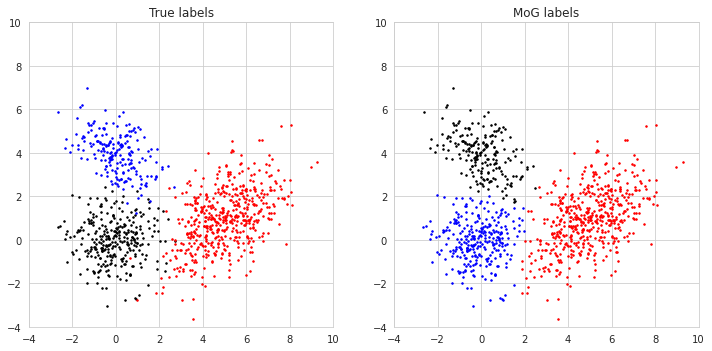

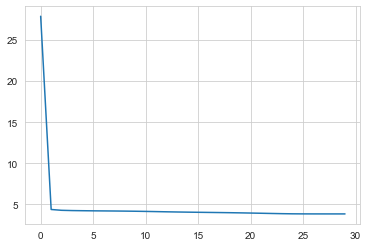

In [14]:
plt.plot(-mll3)

## Task 3: Model complexity
A priori we do not know how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions for extra points. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 2 pts + 1 extra pt*



In [15]:
def mog_bic(x, m, S, p, mll):
    
    '''Compute the BIC for a fitted Mixture of Gaussian model
    
    Parameters
    ----------
    
    x: np.array, (n_samples, n_dims)
        Input data
    
    m: list or np.array, (n_clusters, n_dims)
        Means
    
    S: list or np.array, (n_dims, n_dims, n_clusters)
        Covariances
    
    p: list or np.array, (n_clusters, )
        Cluster weights / probablities    
        
    mll: float 
        mean log likelihood          
    
    
    Return
    ------
    
    bic: float
        BIC
        
    LL: float
        Log Likelihood
    '''
    
    # -------------------------
    # implement the BIC (1.5 pts)
    # -------------------------
    k = p.shape[0]
    LL = mll * x.shape[0]
    
    P = (k * covs.shape[1] * (covs.shape[1] + 1))/2  + k* m.shape[1] + p.shape[0] -1
   
    bic = -2*LL + P*np.log(x.shape[0])

    return (bic, LL)
    

In [16]:

bic2, LL2 = mog_bic(x.T, m=mus2, S=sigmas2, p=pis2, mll= mll2[-1])
bic3, LL3 = mog_bic(x.T, m=mus3, S=sigmas3, p=pis3, mll= mll3[-1])
bic4, LL4 = mog_bic(x.T, m=mus4, S=sigmas4, p=pis4, mll= mll4[-1])
bic5, LL5 = mog_bic(x.T, m=mus5, S=sigmas5, p=pis5, mll= mll5[-1])
bic6, LL6 = mog_bic(x.T, m=mus6, S=sigmas6, p=pis6, mll= mll6[-1])


In [17]:
# ---------------------------------------------------------------------------------------------------
# Compute and plot the BIC for mixture models with different numbers of clusters (e.g., 2 - 6). (0.5 pts)
# Make your algorithm robust against local minima. (1 extra pts)
# ---------------------------------------------------------------------------------------------------
def global_min(bics, cluster_range):
    """ 
    determine global minimum of bics
    
    Parameters
    ----------
    
    bics: np.array
    BICs
    
    cluster_range: np.array
    range of clusters considered
    
    Returns
    -------
    global_min: 
    global minimum
    """
    minima = scipy.signal.argrelmin(bics)
    all_min =np.argsort(bics[minima])
    global_min = cluster_range[minima[all_min[0]]]
    return global_min

In [18]:
bics = np.array([bic2, bic3, bic4, bic5, bic6])
best_n_clusters = global_min(bics, np.arange(2,7))
print("Optimal Cluster No: ",best_n_clusters)

Optimal Cluster No:  [3]


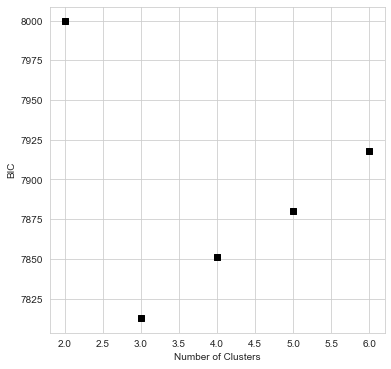

In [19]:
plt.figure(figsize=(6,6))

# insert your code here
plt.scatter(np.arange(2,7),bics, color = "k", marker="s")
plt.xlabel("Number of Clusters")
plt.ylabel("BIC")
plt.show()

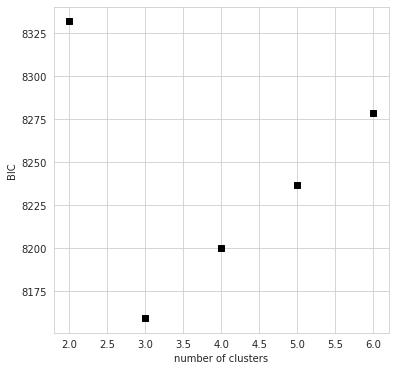

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (including model complexity selection). Plot the BIC as a function of the number of mixture components on the real data. For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot. 

*Grading: 3 pts*


In [20]:
# --------------------------------------------------------------------------
# Select the model that best represents the data according to the BIC (1 pt)
# --------------------------------------------------------------------------
b_pc1 = b[:,0:-1:3]

#Mixture Model 
mlls4_2, pis4_2, mus4_2, sigmas4_2, labels4_2 = fit_mog(b_pc1,k=2, niters=3, random_seed=8)
mlls4_3, pis4_3, mus4_3, sigmas4_3, labels4_3 = fit_mog(b_pc1,k=3, niters=3, random_seed=8)
mlls4_4, pis4_4, mus4_4, sigmas4_4, labels4_4 = fit_mog(b_pc1,k=4, niters=3, random_seed=8)
mlls4_5, pis4_5, mus4_5, sigmas4_5, labels4_5 = fit_mog(b_pc1,k=5, niters=3, random_seed=8)
mlls4_6, pis4_6, mus4_6, sigmas4_6, labels4_6 = fit_mog(b_pc1,k=6, niters=3, random_seed=42)
mlls4_7, pis4_7, mus4_7, sigmas4_7, labels4_7 = fit_mog(b_pc1,k=7, niters=3, random_seed=42)
mlls4_8, pis4_8, mus4_8, sigmas4_8, labels4_8 = fit_mog(b_pc1,k=8, niters=3, random_seed=8)
mlls4_9, pis4_9, mus4_9, sigmas4_9, labels4_9 = fit_mog(b_pc1,k=9, niters=3, random_seed=8)
mlls4_10, pis4_10, mus4_10, sigmas4_10, labels4_10 = fit_mog(b_pc1,k=10, niters=3, random_seed=13)
mlls4_11, pis4_11, mus4_11, sigmas4_11, labels4_11 = fit_mog(b_pc1,k=11, niters=3, random_seed=13)
mlls4_12, pis4_12, mus4_12, sigmas4_12, labels4_12 = fit_mog(b_pc1,k=12, niters=3, random_seed=8)
mlls4_13, pis4_13, mus4_13, sigmas4_13, labels4_13 = fit_mog(b_pc1,k=13, niters=3, random_seed=8)

#BIC
bic4_3, LL4_3 = mog_bic(b_pc1, m=mus4_3, S=sigmas4_3, p=pis4_3, mll= mlls4_3[-1])
bic4_4, LL4_4 = mog_bic(b_pc1, m=mus4_4, S=sigmas4_4, p=pis4_4, mll= mlls4_4[-1])
bic4_5, LL4_5 = mog_bic(b_pc1, m=mus4_5, S=sigmas4_5, p=pis4_5, mll= mlls4_5[-1])
bic4_6, LL4_6 = mog_bic(b_pc1, m=mus4_6, S=sigmas4_6, p=pis4_6, mll= mlls4_6[-1])
bic4_7, LL4_7 = mog_bic(b_pc1, m=mus4_7, S=sigmas4_7, p=pis4_7, mll= mlls4_7[-1])
bic4_8, LL4_8 = mog_bic(b_pc1, m=mus4_8, S=sigmas4_8, p=pis4_8, mll= mlls4_8[-1])
bic4_9, LL4_9 = mog_bic(b_pc1, m=mus4_9, S=sigmas4_9, p=pis4_9, mll= mlls4_9[-1])
bic4_10, LL4_10 = mog_bic(b_pc1, m=mus4_10, S=sigmas4_10, p=pis4_10, mll= mlls4_10[-1])
bic4_11, LL4_11 = mog_bic(b_pc1, m=mus4_11, S=sigmas4_11, p=pis4_11, mll= mlls4_11[-1])
bic4_12, LL4_12 = mog_bic(b_pc1, m=mus4_12, S=sigmas4_12, p=pis4_12, mll= mlls4_12[-1])
bic4_13, LL4_13= mog_bic(b_pc1, m=mus4_13, S=sigmas4_13, p=pis4_13, mll= mlls4_13[-1])

C:\Users\marid\AppData\Local\Temp/ipykernel_7120/378093962.py:31: RuntimeWarning: invalid value encountered in sqrt
  dist_all = np.append(dist_all, np.expand_dims(np.sqrt(dist), axis=0), axis=0)
C:\Users\marid\AppData\Local\Temp/ipykernel_7120/28236725.py:34: RuntimeWarning: invalid value encountered in sqrt
  avg_dist = np.sqrt(dist_c)



Iterations: 7
Mean Log-Likelihood: -24.793278164766367




C:\Users\marid\AppData\Local\Temp/ipykernel_7120/3297716506.py:70: RuntimeWarning: divide by zero encountered in log
  log_cluster_labels = np.log(pis_c)+np.log(np.clip(normal_c, a_min = -10000, a_max=None))


Iterations: 76
Mean Log-Likelihood: -24.56017069207134


Iterations: 41
Mean Log-Likelihood: -24.528634471370346


Iterations: 31
Mean Log-Likelihood: -24.481020559233713


Iterations: 56
Mean Log-Likelihood: -24.43599117206879


Iterations: 66
Mean Log-Likelihood: -24.41654349100512


Iterations: 85
Mean Log-Likelihood: -24.409669514810442


Iterations: 94
Mean Log-Likelihood: -24.402259434242076


Iterations: 66
Mean Log-Likelihood: -24.39127417498764


Iterations: 123
Mean Log-Likelihood: -24.37453684619459


Iterations: 76
Mean Log-Likelihood: -24.363489958139603


Iterations: 88
Mean Log-Likelihood: -24.362741397863665


Refit model with lowest BIC and plot data points

In [21]:
# insert your code here
bics4 = np.array([bic4_3,bic4_4, bic4_5, bic4_6, bic4_7, bic4_8, bic4_9, bic4_10, bic4_11, bic4_12, bic4_13])
optimal_n_clusters = global_min(bics4, np.arange(3,14))
print("Optimal Cluster Number: ",optimal_n_clusters)

Optimal Cluster Number:  [12]


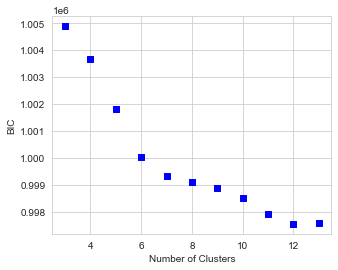

In [22]:
plt.figure(figsize=(5,4))

# insert your code here
plt.scatter(np.arange(3, 14),bics4, color = "b", marker="s")

plt.xlabel("Number of Clusters")
plt.ylabel("BIC")
plt.show()

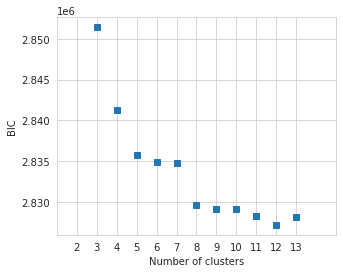

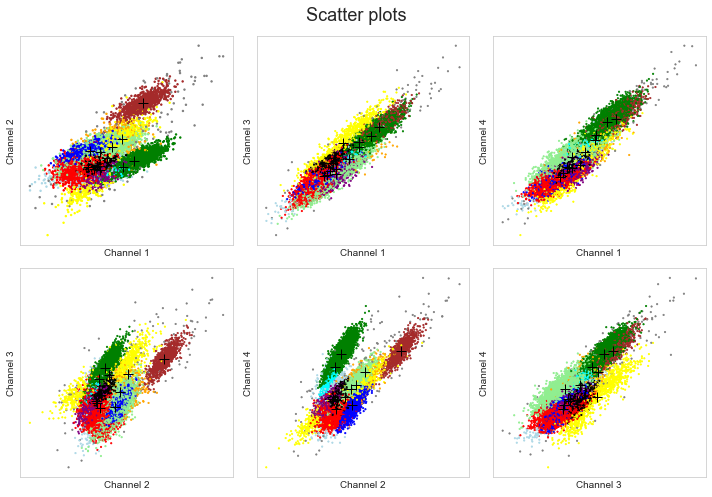

In [23]:
# -------------------------------------------------------------------------------------
# Create scatterplots of the first PCs under the best model for all 4 channels. (2 pts)
# -------------------------------------------------------------------------------------

fig, axs = plt.subplots(2,3, figsize=(10,7))
plt.suptitle('Scatter plots',fontsize=18)

# insert your code here
string_labels4_12 = labels_to_str(labels4_12)

#channel 1 against channel 2 
axs[0][0].scatter(b_pc1[:,0], b_pc1[:,1], color=string_labels4_12, s=2,linewidths= 1)
axs[0][0].scatter(mus4_12[:,0], mus4_12[:,1], s=100,  c='k', marker= '+',linewidths= 1)

axs[0][0].set_xticks([])
axs[0][0].set_yticks([])
axs[0][0].set_xlabel('Channel 1')
axs[0][0].set_ylabel('Channel 2')

#channel 1 against channel 3
axs[0][1].scatter(b_pc1[:,0], b_pc1[:,2], color=string_labels4_12, s=2,linewidths= 0.7)
axs[0][1].scatter(mus4_12[:,0], mus4_12[:,2], s=100,  c='k', marker= '+',linewidths= 1)
axs[0][1].set_xticks([])
axs[0][1].set_yticks([])
axs[0][1].set_xlabel('Channel 1')
axs[0][1].set_ylabel('Channel 3')

#channel 1 against channel 4
axs[0][2].scatter(b_pc1[:,0], b_pc1[:,3], color=string_labels4_12, s=2,linewidths= 0.7)
axs[0][2].scatter(mus4_12[:,0], mus4_12[:,3], s=100,  c='k', marker= '+',linewidths= 1)
axs[0][2].set_xticks([])
axs[0][2].set_yticks([])
axs[0][2].set_xlabel('Channel 1')
axs[0][2].set_ylabel('Channel 4')


#channel 2 against channel 3
axs[1][0].scatter(b_pc1[:,1], b_pc1[:,2], color=string_labels4_12, s=2,linewidths= 0.7)
axs[1][0].scatter(mus4_12[:,1], mus4_12[:,2], s=100,  c='k', marker= '+',linewidths= 1)
axs[1][0].set_xticks([])
axs[1][0].set_yticks([])
axs[1][0].set_xlabel('Channel 2')
axs[1][0].set_ylabel('Channel 3')


#channel 2 against channel 4
axs[1][1].scatter(b_pc1[:,1], b_pc1[:,3], color=string_labels4_12, s=2,linewidths= 0.7)
axs[1][1].scatter(mus4_12[:,1], mus4_12[:,3], s=100,  c='k', marker= '+',linewidths= 1)
axs[1][1].set_xticks([])
axs[1][1].set_yticks([])
axs[1][1].set_xlabel('Channel 2')
axs[1][1].set_ylabel('Channel 4')

#channel 3 against channel 4
axs[1][2].scatter(b_pc1[:,2], b_pc1[:,3], color=string_labels4_12, s=2,linewidths= 0.7)
axs[1][2].scatter(mus4_12[:,2], mus4_12[:,3], s=100,  c='k', marker= '+',linewidths= 1)
axs[1][2].set_xticks([])
axs[1][2].set_yticks([])
axs[1][2].set_xlabel('Channel 3')
axs[1][2].set_ylabel('Channel 4')

plt.tight_layout()
plt.show()

plt.show()

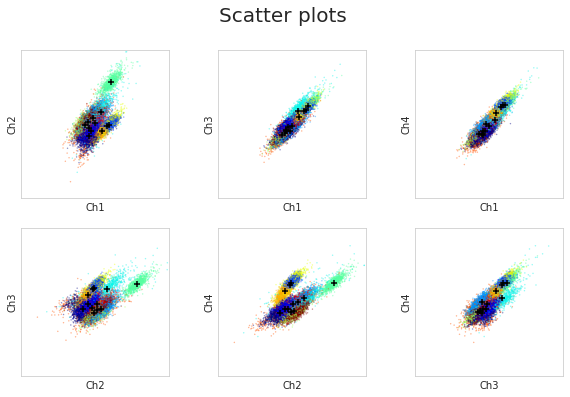

In [24]:
# np.save('../data/nda_ex_2_means',m)
# np.save('../data/nda_ex_2_covs',S)
# np.save('../data/nda_ex_2_pis',p)
# np.save('../data/nda_ex_2_labels',a)